In [1]:
import cv2
import torch
import matplotlib.pyplot as plt

import numpy as np
import sys
sys.path.append('../yolov5')  # Remplacez par le chemin réel vers yolov5

from yolov5.models.common import DetectMultiBackend
from yolov5.utils.general import non_max_suppression
from yolov5.models.common import DetectMultiBackend
from yolov5.utils.plots import Annotator
from yolov5.utils.torch_utils import select_device

im1=cv2.imread('../exemples/test1.jpeg')
plt.imshow(im1)

/Users/martindrieux/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
def scale_coords(img_shape, coords, original_shape):
    """Rescales coords (x1, y1, x2, y2) from `img_shape` to `original_shape`."""
    gain = min(img_shape[0] / original_shape[0], img_shape[1] / original_shape[1])  # gain = old / new
    pad = (img_shape[1] - original_shape[1] * gain) / 2, (img_shape[0] - original_shape[0] * gain) / 2  # width, height
    coords[:, [0, 2]] -= pad[0]  # x padding
    coords[:, [1, 3]] -= pad[1]  # y padding
    coords[:, :4] /= gain
    coords[:, :4] = coords[:, :4].clip(min=0, max=original_shape[1])  # clip coordinates
    return coords

def plot_boxes(image, detections, model_names, color=(0, 255, 0)):
    """Plots bounding boxes with labels on the image."""
    for *xyxy, conf, cls in detections:
        label = f'{model_names[int(cls)]} {conf:.2f}'
        x1, y1, x2, y2 = map(int, xyxy)  # Convert coordinates to integers
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)  # Draw rectangle
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)  # Add label


In [3]:

def resize_and_crop(image, target_size, alpha=1.0):
    """
    Redimensionne et crop une image pour qu'elle s'adapte au target_size sans distorsion.

    Args:
        image (numpy.ndarray): Image d'entrée en format numpy array (BGR ou RGB).
        target_size (tuple): Dimensions cibles (largeur, hauteur) sous forme (w, h).
        alpha (float): Proportion de l'image initiale à garder (0 < alpha ≤ 1).

    Returns:
        numpy.ndarray: Image redimensionnée et croppée à la taille cible.
    """
    if not (0 < alpha <= 1):
        raise ValueError("Alpha doit être compris entre 0 (exclu) et 1 (inclus).")

    orig_h, orig_w = image.shape[:2]
    target_w, target_h = target_size

    # Calculer la taille après le scaling
    scale = max(target_w / (orig_w * alpha), target_h / (orig_h * alpha))
    new_w = int(orig_w * scale)
    new_h = int(orig_h * scale)

    # Redimensionner l'image avec les nouvelles dimensions
    resized_image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Calculer les coordonnées pour croper l'image centrée
    x1 = (new_w - target_w) // 2
    y1 = (new_h - target_h) // 2
    cropped_image = resized_image[y1:y1 + target_h, x1:x1 + target_w]

    return cropped_image/ 255.0


In [4]:
# Set up device
device = select_device('')  # Automatically selects CUDA if available, otherwise CPU

# Load the trained model
model = DetectMultiBackend('/Users/martindrieux/Documents/GitHub/INF573_Puzzle-1/yolov5/runs/train/exp2/weights/best.pt', device=device)
print("Model loaded successfully!")

# Load and preprocess the image
yakari_pieces = cv2.imread('../nos_puzzles/yakari_pieces1.png')  # Read the image
yakari_pieces = cv2.cvtColor(yakari_pieces, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

target_size = (640, 640)
img_resized=resize_and_crop(yakari_pieces, target_size, alpha=0.5)

# Normalize the image (convert pixel values to the range [0, 1])
img_normalized = img_resized / 255.0  # Normalize pixel values

# Convert to a PyTorch tensor and add batch dimension
img_tensor = torch.from_numpy(img_normalized).permute(2, 0, 1).unsqueeze(0).float()  # Shape: [1, 3, 640, 640]

# Send the tensor to the same device as the model
img_tensor = img_tensor.to(model.device)

# Run inference
predictions = model(img_tensor)

# Apply Non-Max Suppression to the predictions
results = non_max_suppression(predictions, conf_thres=0.1, iou_thres=0.4)

# Visualize the results
for det in results:
    if det is not None and len(det):  # Ensure there are detections
        det[:, :4] = scale_coords(img_tensor.shape[2:], det[:, :4], img_resized.shape).round()  # Rescale boxes
        for *xyxy, conf, cls in det:
            # Extract bounding box coordinates
            x_min, y_min, x_max, y_max = map(int, xyxy)
            
            # Draw bounding box
            cv2.rectangle(img_resized, (x_min, y_min), (x_max, y_max), color=(0, 255, 0), thickness=2)
            
            # Add label and confidence
            label = f'{model.names[int(cls)]} {conf:.2f}'
            cv2.putText(
                img_resized,
                label,
                (x_min, y_min - 10),  # Position above the box
                cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=0.5,
                color=(0, 255, 0),
                thickness=2,
            )
    else:
        print("No detections found!")

# Show the final image with bounding boxes
plt.imshow(img_resized)
plt.axis('off')
plt.show()

# Print the results
print("Detection Results:")
print(results)


YOLOv5 🚀 v7.0-383-g1435a8ee Python-3.9.6 torch-2.5.1 CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs


Model loaded successfully!
No detections found!
Detection Results:
[tensor([], size=(0, 6))]


In [5]:
def run_pipeline(image_path, model, target_size, alphas):
    """
    Executes the YOLOv5 detection pipeline and visualizes results for different alpha values.

    Parameters:
    - image_path: Path to the input image.
    - model: Trained YOLOv5 model.
    - target_size: Tuple (width, height) for the resized image.
    - alphas: List of alpha values for cropping proportions.

    Displays:
    - Side-by-side plots of the processed images with bounding boxes.
    """
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(15, 5))

    for i, alpha in enumerate(alphas):
        # Resize and crop the image
        processed_image = resize_and_crop(original_image, target_size, alpha)

        # Normalize and convert to tensor
        img_normalized = processed_image / 255.0
        img_tensor = torch.from_numpy(img_normalized).permute(2, 0, 1).unsqueeze(0).float().to(model.device)

        # Run inference
        predictions = model(img_tensor)
        results = non_max_suppression(predictions, conf_thres=0.1, iou_thres=0.4)

        # Draw bounding boxes
        for det in results:
            if det is not None and len(det):
                det[:, :4] = scale_coords(img_tensor.shape[2:], det[:, :4], processed_image.shape).round()
                for *xyxy, conf, cls in det:
                    x_min, y_min, x_max, y_max = map(int, xyxy)
                    cv2.rectangle(processed_image, (x_min, y_min), (x_max, y_max), color=(0, 255, 0), thickness=2)
                    label = f'{model.names[int(cls)]} {conf:.2f}'
                    cv2.putText(processed_image, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Plot the image
        plt.subplot(1, len(alphas), i + 1)
        plt.imshow(processed_image)
        plt.title(f"Alpha = {alpha}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [6]:
# Set up device and load the model
device = select_device('')
model = DetectMultiBackend('/Users/martindrieux/Documents/GitHub/INF573_Puzzle-1/yolov5/runs/train/exp2/weights/best.pt', device=device)
print("Model loaded successfully!")

# Define parameters
image_path = '../nos_puzzles/yakari_pieces1.png'
target_size = (640, 640)
alphas = [1.0, 0.8, 0.5, 0.3]  # Different proportions to retain in the crop

# Run the pipeline
run_pipeline(image_path, model, target_size, alphas)


YOLOv5 🚀 v7.0-383-g1435a8ee Python-3.9.6 torch-2.5.1 CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs


Model loaded successfully!


In [7]:
def preprocess_image(image, technique='histogram_equalization'):
    """
    Applies preprocessing techniques to improve detection.

    Parameters:
    - image: Input image (NumPy array).
    - technique: Preprocessing technique to apply ('histogram_equalization', 'sharpen', 'blur', 'contrast', 'sharpen_contrast').

    Returns:
    - Preprocessed image.
    """
    if technique == 'histogram_equalization':
        img_yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
        image = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
    elif technique == 'sharpen':
        kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])  # Sharpening kernel
        image = cv2.filter2D(image, -1, kernel)
    elif technique == 'blur':
        image = cv2.GaussianBlur(image, (5, 5), 0)
    elif technique == 'contrast':
        alpha = 1.5  # Contrast control
        beta = 20    # Brightness control
        image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    elif technique == 'sharpen_contrast':
        # Apply sharpening first
        kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])  # Sharpening kernel

        # Then apply contrast adjustment
        alpha = 1.5  # Contrast control
        beta = 20    # Brightness control
        image = cv2.filter2D(image, -1, kernel)
        image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

    return image



def run_pipeline_with_preprocessing(image_path, model, target_size, alphas, techniques):
    """
    Executes the YOLOv5 detection pipeline with preprocessing and visualizes results for different alpha values.

    Parameters:
    - image_path: Path to the input image.
    - model: Trained YOLOv5 model.
    - target_size: Tuple (width, height) for the resized image.
    - alphas: List of alpha values for cropping proportions.
    - techniques: List of preprocessing techniques to apply.

    Displays:
    - Side-by-side plots of the processed images with bounding boxes for each technique.
    """
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(15, 5 * len(techniques)))

    for t, technique in enumerate(techniques):
        # Apply preprocessing technique
        preprocessed_image = preprocess_image(original_image, technique)

        for i, alpha in enumerate(alphas):
            # Resize and crop the image
            processed_image = resize_and_crop(preprocessed_image, target_size, alpha)

            # Normalize and convert to tensor
            img_normalized = processed_image / 255.0
            img_tensor = torch.from_numpy(img_normalized).permute(2, 0, 1).unsqueeze(0).float().to(model.device)

            # Run inference
            predictions = model(img_tensor)
            results = non_max_suppression(predictions, conf_thres=0.1, iou_thres=0.4)

            # Draw bounding boxes
            for det in results:
                if det is not None and len(det):
                    det[:, :4] = scale_coords(img_tensor.shape[2:], det[:, :4], processed_image.shape).round()
                    for *xyxy, conf, cls in det:
                        x_min, y_min, x_max, y_max = map(int, xyxy)
                        cv2.rectangle(processed_image, (x_min, y_min), (x_max, y_max), color=(0, 255, 0), thickness=2)
                        label = f'{model.names[int(cls)]} {conf:.2f}'
                        cv2.putText(processed_image, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

            # Plot the image
            plt.subplot(len(techniques), len(alphas), t * len(alphas) + i + 1)
            plt.imshow(processed_image)
            plt.title(f"{technique} | Alpha = {alpha}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()


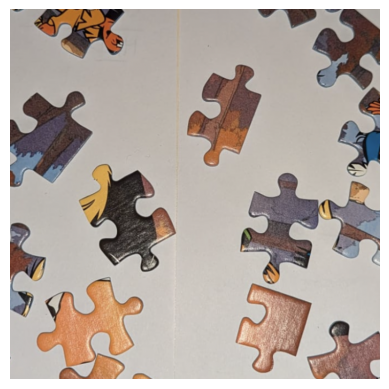

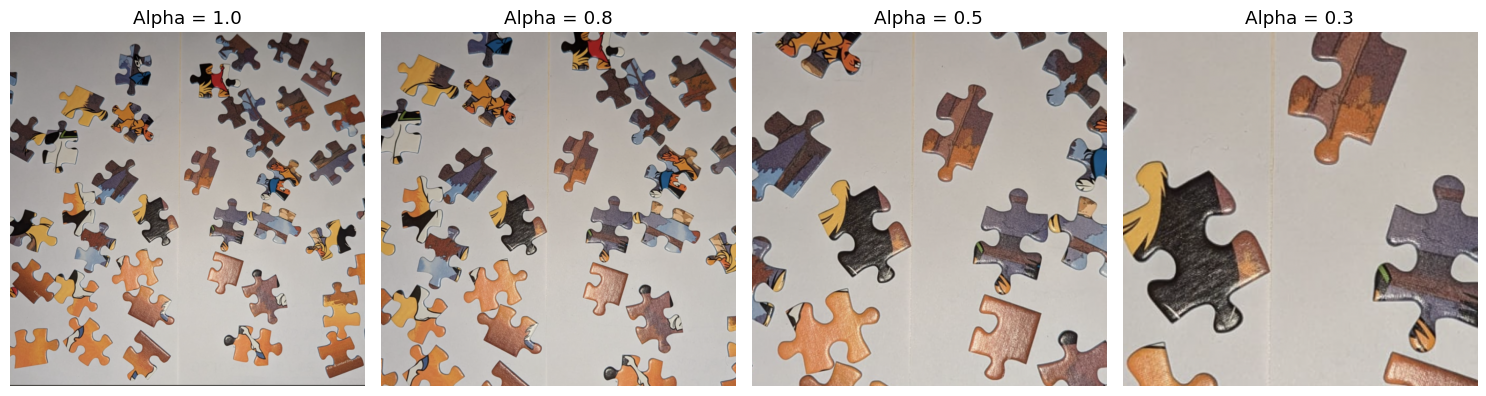

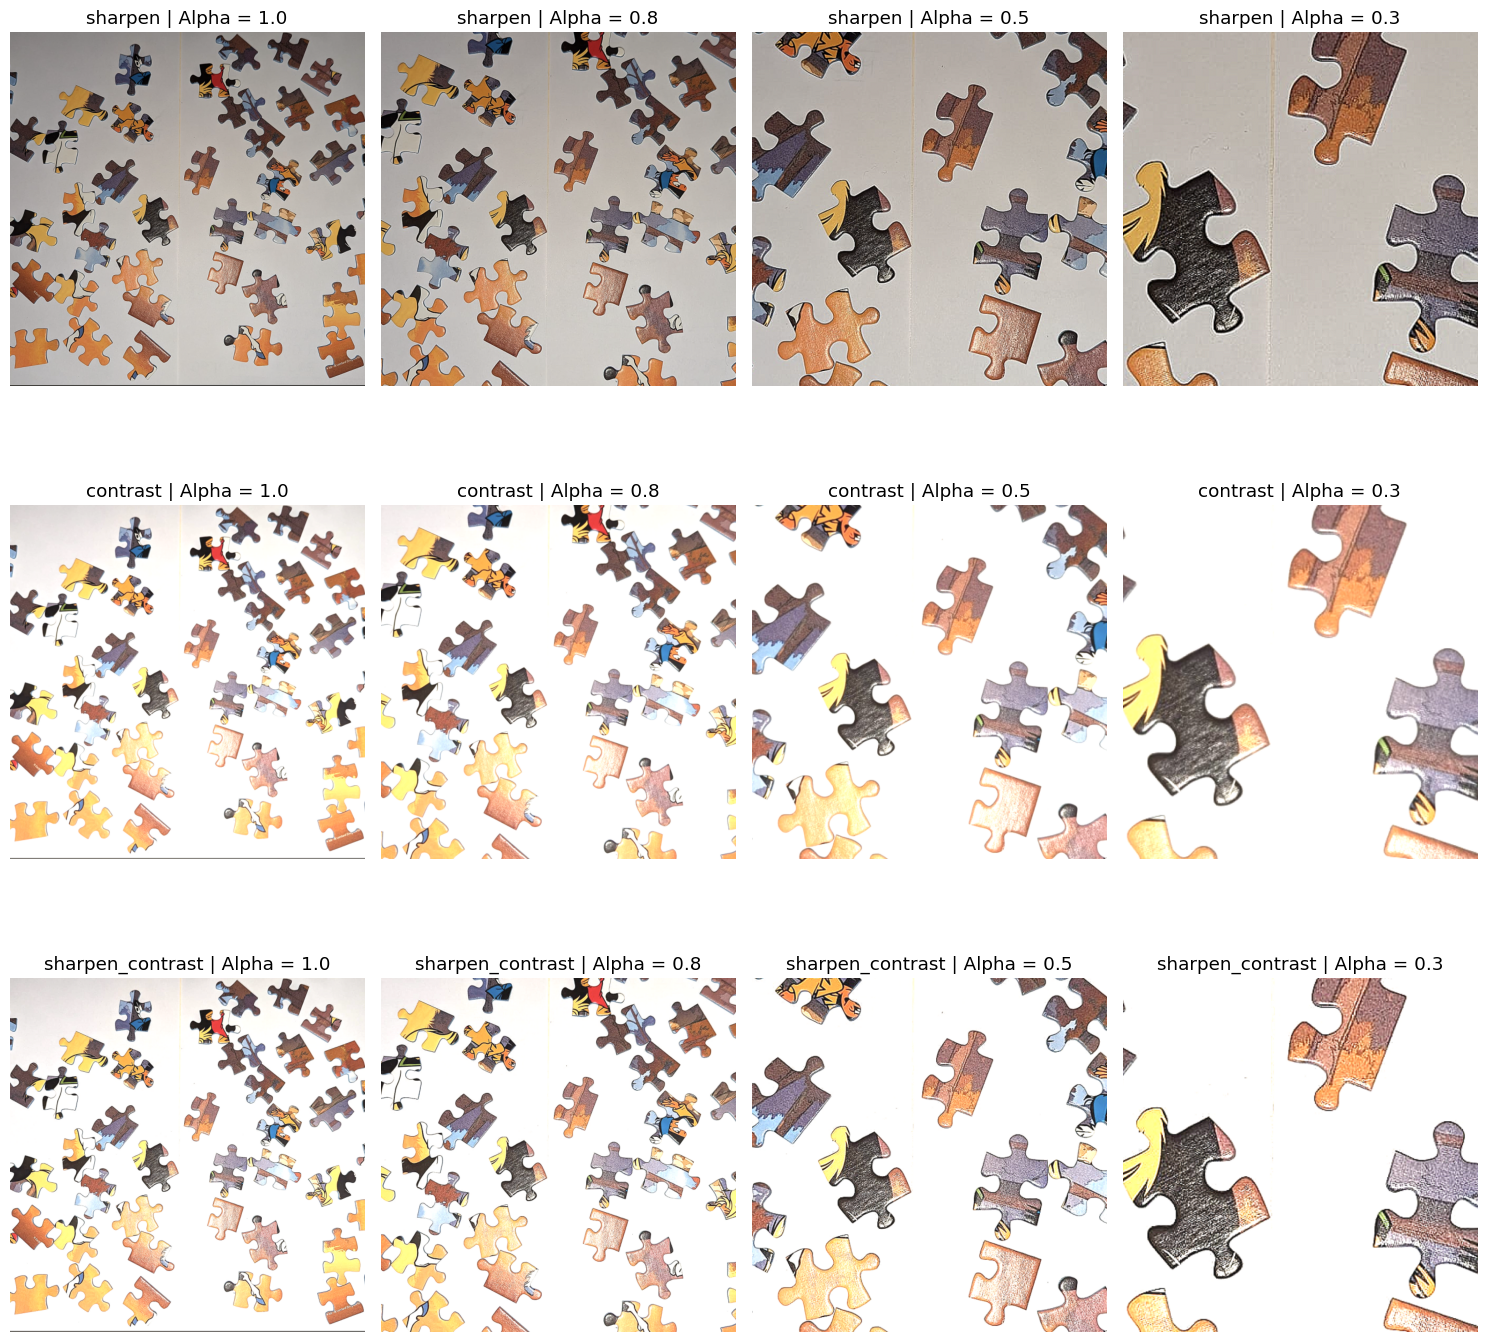

<function matplotlib.pyplot.show(close=None, block=None)>

In [8]:
# Set up device and load the model

%matplotlib inline
# Define parameters
image_path = '../nos_puzzles/yakari_pieces1.png'
target_size = (640, 640)
alphas = [1.0, 0.8, 0.5, 0.3]  # Different proportions to retain in the crop
techniques = [ 'sharpen', 'contrast', 'sharpen_contrast']  # Preprocessing techniques

# Run the pipeline
run_pipeline_with_preprocessing(image_path, model, target_size, alphas, techniques)
plt.show

## Test sur les autres images

In [9]:
im1=cv2.imread('../exemples/test1.jpeg')
im2=cv2.imread('../exemples/test2.jpeg')
im3=cv2.imread('../exemples/test3.jpeg')
im4=cv2.imread('../exemples/test4.jpeg')
im5=cv2.imread('../exemples/test5.jpeg')

path1='../exemples/test1.jpeg'
path2='../exemples/test2.jpeg'
path3='../exemples/test3.jpeg'
path4='../exemples/test4.jpeg'
path5='../exemples/test5.jpeg'

alphas = [1.0, 0.8, 0.5, 0.3, 0.2]

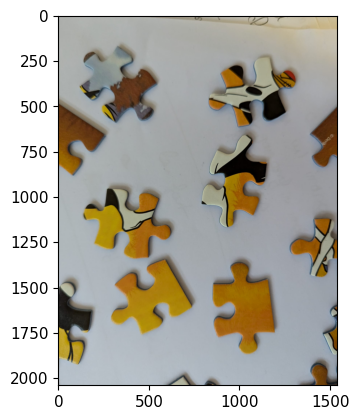

In [10]:

plt.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)) 

### Note : on dirait que y'a un niveau de zoom optimal d'après la taille de la piece 
Ce qu'on peut faire c'est en tester différents, estimer la taille des pièces puis choisir le niveau de zoom optimal

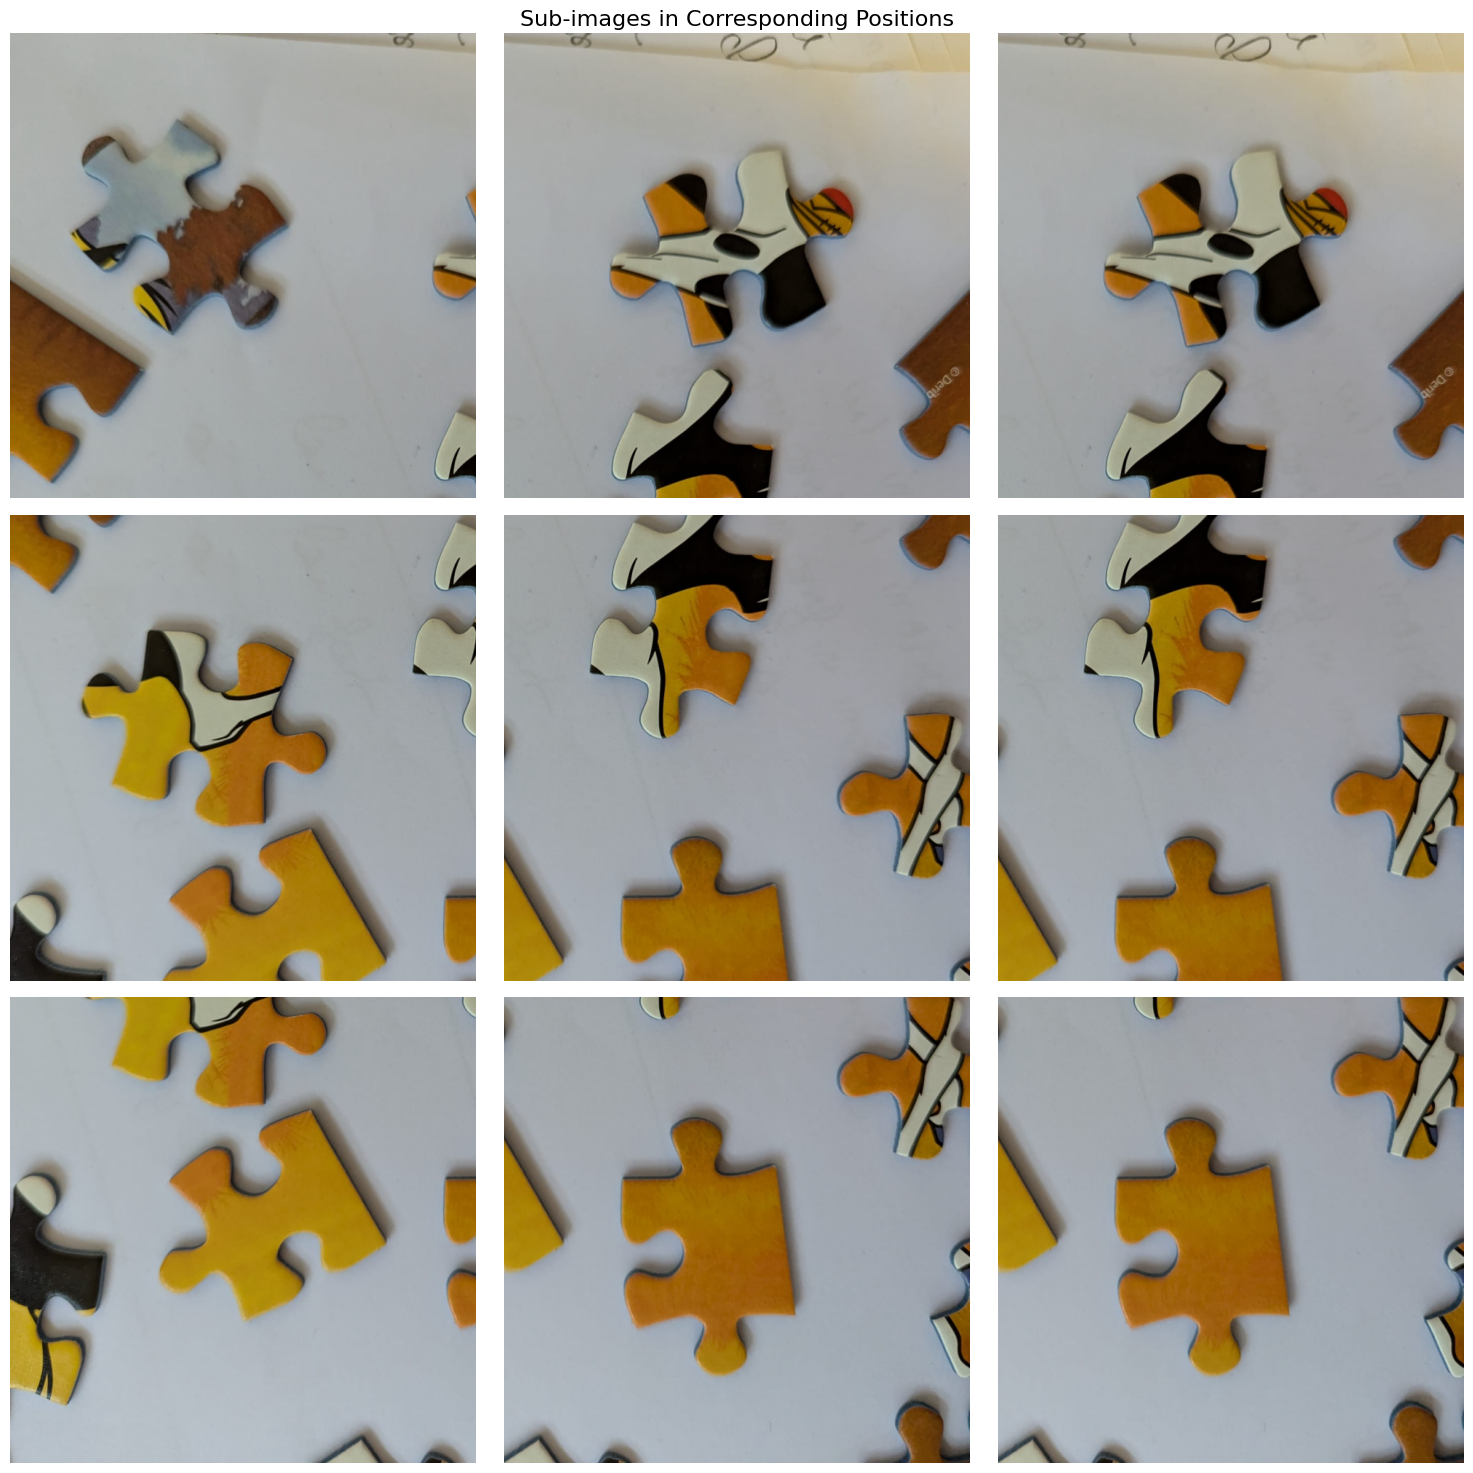

In [11]:
alpha = 0.7
overlap = 0.2

def create_relevant_sub_images(img, alpha, overlap):
    """
    Creates scaled sub-images of size 640x640 with overlap, covering the original image.
    
    Args:
        img (numpy.ndarray): Input image (BGR or RGB).
        alpha (float): Scale factor for resizing (0 < alpha ≤ 1).
        overlap (float): Overlap percentage between consecutive sub-images (0 ≤ overlap < 1).

    Returns:
        list: A list of 640x640 sub-images.
        list: A list of coordinates (x, y, width, height) of the sub-images in the original image.
        int: Number of images per row.
        int: Number of images per column.
    """
    if not (0 < alpha <= 1):
        raise ValueError("Alpha must be in the range (0, 1].")
    if not (0 <= overlap < 1):
        raise ValueError("Overlap must be in the range [0, 1).")
    
    target_size = 640
    orig_h, orig_w = img.shape[:2]

    # Scale the image
    scaled_w = int(orig_w * alpha)
    scaled_h = int(orig_h * alpha)
    scaled_img = cv2.resize(img, (scaled_w, scaled_h), interpolation=cv2.INTER_AREA)

    # Step size for moving the window
    step = int(target_size * (1 - overlap))

    # Calculate number of images per row and column (always cover the entire image)
    num_images_per_row = (scaled_w - 1) // step + 1
    num_images_per_col = (scaled_h - 1) // step + 1

    # Collect sub-images and their coordinates
    sub_images = []
    coordinates = []

    for row in range(num_images_per_col):
        for col in range(num_images_per_row):
            x = min(col * step, scaled_w - target_size)
            y = min(row * step, scaled_h - target_size)
            # Extract sub-image
            sub_img = scaled_img[y:y + target_size, x:x + target_size]
            sub_images.append(sub_img)
            # Map coordinates back to the original image
            orig_x = int(x / alpha)
            orig_y = int(y / alpha)
            orig_w = int(target_size / alpha)
            orig_h = int(target_size / alpha)
            coordinates.append((orig_x, orig_y, orig_w, orig_h))

    return sub_images, coordinates, num_images_per_row, num_images_per_col


sub_images, coordinates, num_images_per_row, num_images_per_col = create_relevant_sub_images(im1, alpha, overlap)

# Create a figure with the appropriate number of subplots
fig, axes = plt.subplots(num_images_per_col, num_images_per_row, figsize=(15, 15))
fig.suptitle('Sub-images in Corresponding Positions', fontsize=16)

# If there's only one row or column, `axes` is not a 2D array, so we need to ensure consistency
if num_images_per_col == 1 or num_images_per_row == 1:
    axes = np.array(axes).reshape(num_images_per_col, num_images_per_row)

# Plot each sub-image in its corresponding position
for idx, sub_img in enumerate(sub_images):
    row = idx // num_images_per_row
    col = idx % num_images_per_row
    axes[row, col].imshow(cv2.cvtColor(sub_img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
    axes[row, col].axis('off')  # Hide axes

# Hide empty subplots if any
for row in range(num_images_per_col):
    for col in range(num_images_per_row):
        if row * num_images_per_row + col >= len(sub_images):
            axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [12]:


# Define parameters


# Generate sub-images and their coordinates
sub_images, coordinates, num_images_per_row, num_images_per_col = create_relevant_sub_images(im1, alpha, overlap)

# Copy the original image to draw rectangles on it
annotated_image = im1.copy()

# Define a list of random colors for rectangles
random.seed(42)
colors = [(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) for _ in range(len(coordinates))]

# Draw rectangles and numbers on the original image
for idx, ((x, y, width, height), color) in enumerate(zip(coordinates, colors)):
    # Draw rectangle
    cv2.rectangle(annotated_image, (x, y), (x + width, y + height), color, 2)
    # Add a label with the sub-image number
    cv2.putText(annotated_image, str(idx + 1), (x + 10, y + 30), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

# Display the original image with rectangles and numbers
plt.figure(figsize=(10, 10))
plt.title("Original Image with Sub-Image Rectangles and Numbers")
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
plt.axis('off')
plt.show()


NameError: name 'random' is not defined